In [2]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import os
import transformers
from accelerate import Accelerator
from transformers import ViTImageProcessor, ViTForImageClassification, ViTModel, ViTConfig, TrainingArguments, Trainer
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np
import cv2
from datasets import load_dataset,load_metric
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

accelerator = Accelerator()
device = accelerator.device

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [6]:
import torch 
from utils.img_utils import generate_mask
from utils import idx_to_selector
import torch.nn.functional as F
import numpy as np


def batch_combine(x, func, n_batch_dims=1):
    """ 
    Temperarily combine multiple dimensions into one batch dimension in order to feed to functions
    that doesn't support multiple batch dimensions.
    Args:
        x: input
        func: function to be passed to
        batch_dims: number of dimensions to be combined, starting from the 0th dimension
    return:
        output having the corresponding shape of x
    """
    shape = x.shape
    batch_shape, rest_shape = shape[:n_batch_dims + 1], shape[n_batch_dims + 1:]
    combined_batch_shape = [np.prod(batch_shape),]
    res = func(x.reshape(combined_batch_shape + rest_shape))
    return res.reshape(batch_shape + rest_shape)


class BatchRandomMaskSaliency():
    """
    Batched version of RandomMaskSaliency
    """

    def __init__(self, model, num_classes):
        """
        Initialize the BatchRandomMaskSaliency class.

        Args:
            model: The model that outputs logits.
            num_classes: The number of classes.

        Returns:
            None
        """
        super().__init__()

        self.model = model
        self.num_classes = num_classes
    

    def attribute_img(self, 
                      x, 
                      image_size=224, 
                      patch_size=16, 
                      baseline=None, 
                      n_samples=1000,
                      mask_prob=0.7,
                      seed=None):
        """
        Generate attribution heatmap for an input image.

        Args:
            x: An image tensor of shape [N, C, H, W], where H = W = image_size.
            image_size: The size of the input image (H = W = image_size).
            patch_size: The size of each patch. Can be used to calculate the number of tokens in each patch 
                        (image_size // patch_size) ** 2.
            baseline: The baseline tensor. If None, the baseline is set to the zero tensor.
            n_samples: The number of random masks to be generated.
            mask_prob: The probability of a token being masked, i.e., replaced by the baseline.
            seed: The seed value for random number generation.

        Returns:
            Attribution heatmap.
        """

        device = x.device
        size = image_size // patch_size
        N, C, H, W = x.shape
        with torch.no_grad():
            # Get the original prediction idx and the selector
            predicted_class_idx = self.model(x).argmax(-1) # [N, 1]
            selector = idx_to_selector(predicted_class_idx, self.num_classes) # [N, n_classes]
            selector = selector.unsqueeze(1) # [N, 1, n_classes]

            # Generate a random mask and reshape to the proper size.
            mask = generate_mask(mask_size=size*size, mask_probability=mask_prob, batch_size=n_samples*N, seed=seed)
            mask = mask.to(device)
            mask = mask.reshape(-1, 1, size, size) # [n_samples*N, 1, size, size]

            # Interpolate mask to the size of the original image.
            masked_pixels = F.interpolate(mask, x.shape[-2:], mode='nearest') # [n_samples*N, 1, H, W]

            # A number of `n_samples` randomly masked inputs
            x_expand = x.unsqueeze(1).expand(-1, n_samples, -1, -1, -1).reshape(N*n_samples, C, H, W) # [N * n_samples, C, H, W]
            x_masked = x_expand * (1 - masked_pixels) # [N*n_samples, C, H, W]

            # Obtain the output probabilities of the masked inputs for the true predicted class.
            logits = self.model(x_masked) # [N*n_samples, n_classes]
            logits = logits.reshape(N, n_samples, self.num_classes)  # [N, n_samples, n_classes]
            probs = torch.softmax(logits, dim=-1) # [N, n_samples, n_classes]


            # Only consider the masks with correct predictions. Weighted usign probs
            correct_idx = (logits.argmax(-1) == predicted_class_idx.unsqueeze(-1)).float() # [N, n_samples, 1]
            probs = ((probs * selector) * correct_idx).sum(-1, keepdim=True) # [N, n_samples, 1]
            probs = probs.unsqueeze(-1).unsqueeze(-1) # [N, n_samples, 1, 1, 1]

            # Weighted mask
            mask = mask.reshape(N, n_samples, 1, size, size) # [N, n_samples, 1, size, size]
            weighted_mask = (probs * (1 - mask)).sum(1) / probs.sum(1) # [N, 1, size, size]
        
        return weighted_mask
    
    def attribute_text(self, x, baseline=None, n_samples=1000,):
        # TODO
        raise NotImplementedError("This function hasn't been developed.")



# Load Model

In [7]:
# url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
# url = "http://farm3.staticflickr.com/2066/1798910782_5536af8767_z.jpg"
# url = "http://farm1.staticflickr.com/184/399924547_98e6cef97a_z.jpg"
url = "http://farm1.staticflickr.com/128/318959350_1a39aae18c_z.jpg"
image = Image.open(requests.get(url, stream=True).raw)

pretrained_name = 'google/vit-base-patch16-224'
# pretrained_name = 'vit-base-patch16-224-finetuned-imageneteval'
# pretrained_name = 'openai/clip-vit-base-patch32'
config = ViTConfig.from_pretrained(pretrained_name)
processor = ViTImageProcessor.from_pretrained(pretrained_name)
# get mean and std to unnormalize the processed images
mean, std = processor.image_mean, processor.image_std

pred_model = ViTForImageClassification.from_pretrained(pretrained_name)
pred_model.to(device)
# set to eval mode
pred_model.eval()

inputs = processor(images=image, return_tensors="pt")
inputs.to(device)
outputs = pred_model(**inputs, output_hidden_states=True)
logits = outputs.logits
# model predicts one of the 1000 ImageNet classes
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", pred_model.config.id2label[predicted_class_idx])

Predicted class: golden retriever


# Load RandomMaskSaliency Model

In [8]:

model = lambda x: pred_model(pixel_values=x).logits
random_mask = BatchRandomMaskSaliency(model, num_classes=config.num_labels)

attr = random_mask.attribute_img(inputs['pixel_values'],
                                image_size=config.image_size, 
                                patch_size=config.patch_size, 
                                n_samples=1000, 
                                mask_prob=0.7)

In [9]:
attr.shape

torch.Size([1, 1, 14, 14])

## Show Example

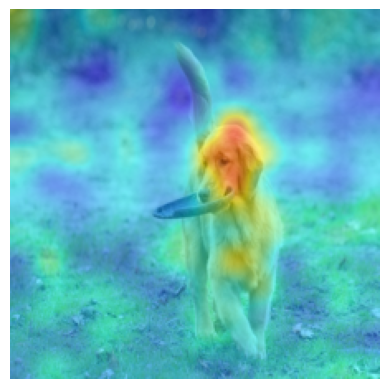

In [10]:
from utils.img_utils import unnormalize, unnormalize_and_255_scale, show_superimposed, get_overlap, plot_overlap, plot_overlap_np


img = inputs['pixel_values'].squeeze(0).detach().cpu().numpy().transpose(1,2,0)

heatmap = attr[0,0].cpu().detach().numpy()

img_int, heatmap_img = plot_overlap_np(img, heatmap, mean, std)

# Batch Evaluation

In [5]:
from torch.utils.data import DataLoader
def load_data(seed=42): 
    dataset = load_dataset("mrm8488/ImageNet1K-val")
    dataset = dataset['train']
    splits = dataset.train_test_split(test_size=0.1, seed=seed)
    test_ds = splits['test']
    splits = splits['train'].train_test_split(test_size=0.1, seed=seed)
    train_ds = splits['train']
    val_ds = splits['test']
    return train_ds, val_ds, test_ds

_, _, test_ds = load_data()

normalize = Normalize(mean=processor.image_mean, std=processor.image_std)
if "height" in processor.size:
    size = (processor.size["height"], processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in processor.size:
    size = processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = processor.size.get("longest_edge")

transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

test_ds.set_transform(preprocess)

# batch size is limited to 2, because n_steps could could huge memory consumption
batch_size = 1
test_dataloader = DataLoader(test_ds, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

Repo card metadata block was not found. Setting CardData to empty.


In [9]:
from evaluation import EvalGame
from tqdm import tqdm

# random_mask
root_path = 'results/mask-vit'
topk = 50

eval_game = EvalGame(model=lambda x : pred_model(pixel_values=x).logits, output_dim=1000)

def save_heatmap(heatmap, batch_size, idx, root_path):
    # convert to numpy
    heatmap = heatmap.detach().cpu().numpy() # [N, 1, 14, 14]
    tail_index = batch_size * (idx + 1)
    file_name = os.path.join(root_path, f"heatmap-{tail_index}")
    np.save(file_name, heatmap)
    
    return 0
    

ins_score_list = []
del_score_list = []
heatmap_list = []


for idx, data in tqdm(enumerate(test_dataloader)):
    pixel_values = data['pixel_values'].to(device)
    with torch.no_grad():
        pseudo_label = model(pixel_values).argmax(-1).view(-1)

    # sum up all 3 RGB channels for heatmap
    attr = random_mask.attribute_img(pixel_values,
                                    image_size=config.image_size, 
                                    patch_size=config.patch_size, 
                                    n_samples=1000, 
                                    mask_prob=0.7) # [1,1,14,14]

    heatmap = attr.squeeze(1) # [1, 14, 14]
    heatmap_list.append(heatmap)
    if (idx + 1) * batch_size % 100 == 0:
        heatmap_cat_tensor = torch.cat(heatmap_list, dim=0) # (N, 14, 14)
        save_heatmap(heatmap_cat_tensor, batch_size, idx, root_path)
        heatmap_list = []

    # with torch.no_grad():
    #     input_img = pixel_values
    #     ins_score = eval_game.get_insertion_at_topk(input_img, heatmap, topk).detach()
    #     del_score = eval_game.get_deletion_at_topk(input_img, heatmap, topk).detach()

    #     # append to list
    #     ins_score_list.append(ins_score)
    #     del_score_list.append(del_score)

if len(heatmap_list > 0):
    heatmap_cat_tensor = torch.cat(heatmap_list, dim=0) # (N, 224, 224)
    save_heatmap(heatmap_cat_tensor, batch_size, idx, root_path)

# ins_score = torch.cat(ins_score_list, dim=0)
# del_score = torch.cat(del_score_list, dim=0)

1539it [1:04:11,  2.50s/it]

In [7]:
# from evaluation import EvalGame
# import os 
# import re
# from tqdm import tqdm


# root_path = 'results/mask-vit'
# model = lambda x: pred_model(pixel_values=x).logits
# eval_game = EvalGame(model=lambda x : pred_model(pixel_values=x).logits, output_dim=1000)
# topk = 50

# def extract_number(filename):
#     """
#     Extract the first occurance of countinuous numbers in a file name
#     """
#     match = re.search(r'\d+', filename)
#     if match:
#         return int(match.group(0))
#     return 0

# def get_ordered_filename_list(root_path):
#     file_path_list = []
#     for filename in os.listdir(root_path):
#         if filename.endswith('.npy'):
#             file_path = os.path.join(root_path, filename)
#             file_path_list.append(file_path)
#     file_path_list = sorted(file_path_list, key=extract_number)
#     return file_path_list


# def load_heatmap(root_path):
#     file_path_list = get_ordered_filename_list(root_path)
#     for filename in file_path_list:
#        yield np.load(filename)


# ins_score_list = []
# del_score_list = []

# heatmap_generator = load_heatmap(root_path)
# test_dataloader_iterator = iter(test_dataloader)
# for idx, data in tqdm(enumerate(heatmap_generator)):
#     heatmap = torch.tensor(data, device=device)

#     with torch.no_grad():
#         # Average pooling to convert to 14*14 heatmap
#         heatmap = F.avg_pool2d(heatmap, kernel_size=16, stride=16)
#         input_img = next(test_dataloader_iterator)['pixel_values'].to(device)
#         ins_score = eval_game.get_insertion_at_topk(input_img, heatmap, topk).detach()
#         del_score = eval_game.get_deletion_at_topk(input_img, heatmap, topk).detach()

#         # append to list
#         ins_score_list.append(ins_score)
#         del_score_list.append(del_score)

7it [00:19,  2.72s/it]


KeyboardInterrupt: 

In [ ]:
ins_score = torch.cat(ins_score_list, dim=0)
del_score = torch.cat(del_score_list, dim=0)
print(ins_score.mean())
print(del_score.mean())

tensor(0.6008, device='cuda:0')
tensor(0.5319, device='cuda:0')


2500it [53:30,  1.28s/it]


RuntimeError: torch.cat(): expected a non-empty list of Tensors

In [ ]:
ins_score = torch.cat(ins_score_list, dim=0)
del_score = torch.cat(del_score_list, dim=0)

In [ ]:
ins_score.mean()

tensor(0.0598, device='cuda:0')

In [ ]:
del_score.mean()

tensor(0.8612, device='cuda:0')

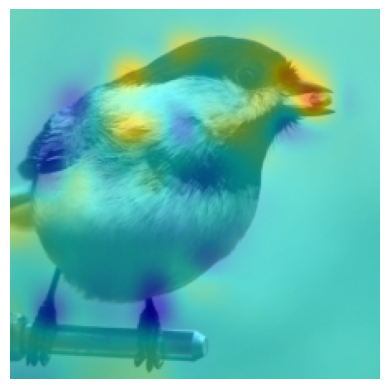

In [ ]:
heatmap_example = heatmap[1].detach().cpu().numpy()
img_example = pixel_values[1].detach().cpu().numpy().transpose(1,2,0)

_, _ = plot_overlap_np(img_example, heatmap_example, mean, std)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


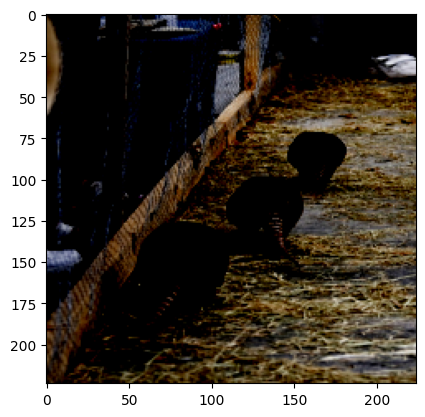